# Random Forest

**Author:** Elisa Warner  
**Date:** 04/29/2022  
**Description:** An implementation of Random Forest. In this case, we use sklearn's decision tree for simplification

In [2]:
# load libraries
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve, auc
from sklearn import tree # for decision tree models
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load data
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
depth = 3
numTrees = 10

In [17]:
class RandomForest():
    def __init__(self, data, labels, depth, numTrees):
        self.data = data
        self.labels = labels
        self.depth = depth
        self.numTrees = numTrees
        self.rowSize = data.shape[0]
        self.featureList = []
        self.forest = []
        # the below variable is the number of features which will be included in each bootstrapped sample for each tree in the forest
        self.numFeatures = np.max((self.depth, int(0.3 * len(list(data)))))
        
        # create oob set, train set
        self.train, self.trainLabels = self.sample(self.data, self.labels, 0.7)
        oob_idx = np.array(list(set(self.data.index.values) - set(self.train.index.values)))
        self.test = self.data.loc[oob_idx]
        self.testLabels = self.labels.loc[oob_idx]
        print('Train size:', self.train.shape, '\nTest size:', self.test.shape)      
    
    
    """
    [FUNCTION] sample()
        Input: dataframe of data, series of the labels, percent of dataset to sample, number of features allowed in feature bag
        Output: [dataFrame] One bootstrapped sample of the data based on the input parameters 
    """
    def sample(self, data, labels, p, num_feat_bag = 0):
        rowSize = data.shape[0]
        m = int(rowSize * p)
        idx = np.random.choice(np.arange(rowSize), m, replace = False)
        
        if num_feat_bag > 0:
            feat_bag = np.random.choice(list(data), num_feat_bag, replace = False)
            return data.iloc[idx][feat_bag], labels.iloc[idx]
        else:
            return data.iloc[idx], labels.iloc[idx]

    """
    [FUNCTION] createTree()
        Input: None
        Output: None
        Description: Creates the Random "Forest" from multiple decision trees
    """
    def createTree(self, data, labels):
        
        forest = []
        features = []
        
        # create forest
        for i in range(numTrees):
            treeData, treeLabels = self.sample(data, labels, 0.7, self.numFeatures) # bootstrap, restrict feature bag
            features.append(list(treeData))
            
            clf = tree.DecisionTreeClassifier(random_state = 0)
            model = clf.fit(treeData, treeLabels)
            forest.append(model)
        
        return (forest, features)

    """
    [FUNCTION] randomForest()
        Input: None
        Output: None
        Description: runs the Random Forest model
    """
    def randomForest(self):
        (forest, features) = self.createTree(self.train, self.trainLabels)
        self.forest = self.forest + forest
        self.featureList = self.featureList + features
    
    """
    [FUNCTION] createTree()
        Input: dataframe of data
        Output: [numpy array] the random forest prediction probability outputs
    """
    # gather the trees togther and average the result
    def predictFromTree(self, data, forest, featureList):
        treeOutput = np.zeros((self.numTrees, data.shape[0]))
        for idx, model in enumerate(forest):
            treeOutput[idx, :] = treeOutput[idx, :] + model.predict_proba(data[featureList[idx]])[:,1]
        
        return np.sum(treeOutput, axis = 0) / numTrees
    
    
    """
    [FUNCTION] oobTest()
        Input: None
        Output: None
        Description: Outputs the ROC curve for RandomForest predictions
    """
    def runTest(self, testdata, testlabels, forest, featureList):
        # predict results
        predicted = self.predictFromTree(testdata, forest, featureList)
        
        # Code quoted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        fpr, tpr, _ = roc_curve(testlabels, predicted)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        lw = 2
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating curve for OOB Test Set")
        plt.legend(loc="lower right")
        plt.show()
    
    """
    [FUNCTION] oobTest()
        Input: None
        Output: None
        Description: Test non-privileged RF with OOB sample
    """
    def oobTest(self):
        self.runTest(self.test, self.testLabels, self.forest, self.featureList)

Train size: (398, 30) 
Test size: (171, 30)


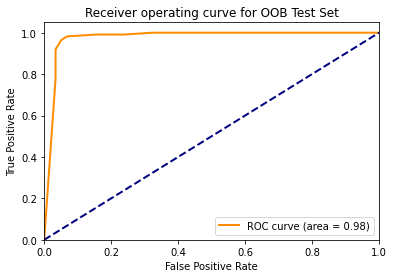

In [18]:
a = RandomForest(X, y, depth, numTrees)
a.randomForest()
a.oobTest()